In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pprint import pprint

import ceci
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import yaml
from IPython.display import Image
from astropy.table import Table

import re
import sacc

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [3]:
# user specific paths -- IN2P3 example
#my_txpipe_dir = "/sps/lsst/users/ebarroso/TXPipe/"
my_txpipe_dir = "/global/homes/e/edujb/TXPipe/"
import sys
sys.path.insert(0, my_txpipe_dir) 
# user specific paths -- NERSC example
# my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

#os.chdir(my_txpipe_dir)

import txpipe

___

In [4]:
step1 = txpipe.TXSourceSelectorMetadetect.make_stage(
    # This file is the input metadetect shear catalog
    shear_catalog=f"{my_txpipe_dir}/data/example/inputs/metadetect_shear_catalog.hdf5",
    # This is an input training set for the tomographic selection
    calibration_table=f"{my_txpipe_dir}data/example/inputs/sample_cosmodc2_w10year_errors.dat",

    # This contains all the options for this stage. You can override them here
    # manually too.
    config=f"{my_txpipe_dir}/examples/metadetect/config.yml",

    # This is the output file for this stage
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect/shear_tomography_catalog.hdf5"
)

In [5]:
step1.run()
step1.finalize()

Process 0 running selection for rows 0-82,200


In [6]:
shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect_20/shear_tomography_catalog.hdf5"
with h5py.File(shear_tomography_catalog, 'r') as file:
# List all groups in the file
    print("Keys:", list(file.keys()))
    #print(file["counts"])
    display(list(file["counts"]["mean_e1"]))
    #display(list(file["tomography"]["bin"]))


Keys: ['counts', 'provenance', 'response', 'tomography']


[np.float32(0.00090161833),
 np.float32(0.0014274995),
 np.float32(-0.00015233812),
 np.float32(0.00078499416)]

In [7]:
step2 = txpipe.CLClusterBinningRedshiftRichness.make_stage(
    # This file is the input metadetect shear catalog
    cluster_catalog=f"{my_txpipe_dir}data/example/inputs/cluster_catalog.hdf5",
    # This is an input training set for the tomographic selection

    # This contains all the options for this stage. You can override them here
    # manually too.
    config=f"{my_txpipe_dir}/notebooks/cluster_counts/gt_treecor_test/config-1deg2-CL.yml",

    # This is the output file for this stage
    cluster_catalog_tomography=f"{my_txpipe_dir}/data/example/output_binning/cluster_catalog_tomography.hdf5"
)



In [8]:
step2.run()
step2.finalize()

In [9]:
cluster_catalog_tomography=f"{my_txpipe_dir}/data/example/output_binning/cluster_catalog_tomography.hdf5"
with h5py.File(cluster_catalog_tomography, 'r') as file:
# List all groups in the file
    print("Keys:", list(file.keys()))
    print(list(file["cluster_bin"]["bin_zbin_0_richbin_0"]))
    print(len(list(file["cluster_bin"]["bin_zbin_0_richbin_0"]["cluster_id"])))
    print(list(file["cluster_bin"]["bin_zbin_0_richbin_0"]["redshift"]))
    print(list(file["cluster_bin"]["bin_zbin_0_richbin_0"].attrs))
    test = file["cluster_bin"]["bin_zbin_0_richbin_0"].attrs
    print(test["rich_max"])
    print(list(file["provenance"].keys()))
    print(list(file["cluster_bin"])[3])


cluster_catalog_tomography = f"{my_txpipe_dir}/data/example/outputs_metadetect/shear_tomography_catalog.hdf5"

with h5py.File(cluster_catalog_tomography, "r") as f:
    tomo = f["tomography"]
    print("Tomography contents:", list(tomo.keys()))
    print("\nAttributes of tomography group:")
    for a, v in tomo.attrs.items():
        print(f"  {a}: {v}")

    # Now print one dataset info
    first_key = list(tomo.keys())[0]
    print(f"\nInspecting first dataset: {first_key}")
    print("Shape:", tomo[first_key].shape)
    print("Dtype:", tomo[first_key].dtype)
    print("Attributes:")
    for a, v in tomo[first_key].attrs.items():
        print(f"  {a}: {v}")
    print("First few values:", tomo[first_key][:10])


Keys: ['cluster_bin', 'provenance']
['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']
5
[np.float64(0.2546227276325226), np.float64(0.23431362211704254), np.float64(0.28674596548080444), np.float64(0.344936341047287), np.float64(0.24044087529182434)]
['rich_max', 'rich_min', 'z_max', 'z_min']
10.0
[]
bin_zbin_1_richbin_1
Tomography contents: ['bin']

Attributes of tomography group:
  catalog_type: metadetect
  nbin: 4
  zmax_0: 0.7
  zmax_1: 0.9
  zmax_2: 1.1
  zmax_3: 2.0
  zmin_0: 0.5
  zmin_1: 0.7
  zmin_2: 0.9
  zmin_3: 1.1

Inspecting first dataset: bin
Shape: (82200,)
Dtype: int32
Attributes:
First few values: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [10]:
step3 = txpipe.TXShearCalibration.make_stage(
    # This file is the input metadetect shear catalog
    shear_catalog=f"{my_txpipe_dir}/data/example/inputs/metadetect_shear_catalog.hdf5",
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    binned_shear_catalog=f"{my_txpipe_dir}data/example/output_shearcalib/binned_shear_catalog.hdf5",
)

In [11]:
step3.run()
step3.finalize()

Copying extra columns:  []
Copying magnitude:  ['mag_i', 'mag_r', 'mag_z', 'mag_err_i', 'mag_err_r', 'mag_err_z']
Using calibration method: MetaDetectCalibrator
Reading these columns from the 'shear' group:
 - 00/g1
 - 00/g2
 - 00/ra
 - 00/dec
 - 00/weight
 - 00/mag_i
 - 00/mag_r
 - 00/mag_z
 - 00/mag_err_i
 - 00/mag_err_r
 - 00/mag_err_z
Renaming these columns:
 - 00/g1 -> g1
 - 00/g2 -> g2
 - 00/ra -> ra
 - 00/dec -> dec
 - 00/weight -> weight
 - 00/mag_i -> mag_i
 - 00/mag_r -> mag_r
 - 00/mag_z -> mag_z
 - 00/mag_err_i -> mag_err_i
 - 00/mag_err_r -> mag_err_r
 - 00/mag_err_z -> mag_err_z
Process 0 collating bins: [0, 1, 2, 3, all]
Rank 0 processing data 0 - 82,200


In [12]:
import h5py

binned_shear_catalog = f"{my_txpipe_dir}data/example/output_shearcalib/binned_shear_catalog.hdf5"

with h5py.File(binned_shear_catalog, "r") as f:
    # Step 1: provenance
    print("\n=== Provenance keys ===")
    print(list(f["provenance"].keys()))

    # Step 2: shear group structure
    shear = f["shear"]
    print("\n=== Shear group keys ===")
    print(list(shear.keys()))

    # Step 3: list all subgroups and their contents + attributes
    for b in shear.keys():
        print(f"\n--- {b} ---")
        g = shear[b]
        print("Datasets:", list(g.keys()))
        print("Attributes:")
        for k, v in g.attrs.items():
            print(f"  {k}: {v}")



=== Provenance keys ===
[]

=== Shear group keys ===
['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_all']

--- bin_0 ---
Datasets: ['dec', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_i', 'mag_r', 'mag_z', 'ra', 'weight']
Attributes:

--- bin_1 ---
Datasets: ['dec', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_i', 'mag_r', 'mag_z', 'ra', 'weight']
Attributes:

--- bin_2 ---
Datasets: ['dec', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_i', 'mag_r', 'mag_z', 'ra', 'weight']
Attributes:

--- bin_3 ---
Datasets: ['dec', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_i', 'mag_r', 'mag_z', 'ra', 'weight']
Attributes:

--- bin_all ---
Datasets: ['dec', 'g1', 'g2', 'mag_err_i', 'mag_err_r', 'mag_err_z', 'mag_i', 'mag_r', 'mag_z', 'ra', 'weight']
Attributes:


In [13]:
cluster_tomo = h5py.File(f"{my_txpipe_dir}/data/example/output_binning/cluster_catalog_tomography.hdf5")
#print(cluster_tomo["cluster_bin"][0])


with h5py.File("/global/homes/e/edujb/TXPipe/cluster_catalog_tomography.hdf5", "r") as f:
    def print_structure(name):
        print(name)
    f.visit(print_structure)
    for j, bin_name in enumerate(f["cluster_bin"].keys()):
        print(bin_name)
    print(f["cluster_bin/bin_zbin_0_richbin_0/redshift"][:])

cluster_bin
cluster_bin/bin_zbin_0_richbin_0
cluster_bin/bin_zbin_0_richbin_0/cluster_id
cluster_bin/bin_zbin_0_richbin_0/dec
cluster_bin/bin_zbin_0_richbin_0/ra
cluster_bin/bin_zbin_0_richbin_0/redshift
cluster_bin/bin_zbin_0_richbin_0/redshift_err
cluster_bin/bin_zbin_0_richbin_0/richness
cluster_bin/bin_zbin_0_richbin_0/richness_err
cluster_bin/bin_zbin_0_richbin_0/scaleval
cluster_bin/bin_zbin_0_richbin_1
cluster_bin/bin_zbin_0_richbin_1/cluster_id
cluster_bin/bin_zbin_0_richbin_1/dec
cluster_bin/bin_zbin_0_richbin_1/ra
cluster_bin/bin_zbin_0_richbin_1/redshift
cluster_bin/bin_zbin_0_richbin_1/redshift_err
cluster_bin/bin_zbin_0_richbin_1/richness
cluster_bin/bin_zbin_0_richbin_1/richness_err
cluster_bin/bin_zbin_0_richbin_1/scaleval
cluster_bin/bin_zbin_1_richbin_0
cluster_bin/bin_zbin_1_richbin_0/cluster_id
cluster_bin/bin_zbin_1_richbin_0/dec
cluster_bin/bin_zbin_1_richbin_0/ra
cluster_bin/bin_zbin_1_richbin_0/redshift
cluster_bin/bin_zbin_1_richbin_0/redshift_err
cluster_bin/bi

In [14]:
step3 = txpipe.extensions.cluster_counts.TXTwoPointClusterSource.make_stage(
    # This file is the input metadetect shear catalog
    binned_lens_catalog=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",
    # This is an input training set for the tomographic selection
    binned_shear_catalog=f"{my_txpipe_dir}data/example/output_shearcalib/binned_shear_catalog.hdf5",
    binned_random_catalog=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",
    patch_centers=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",
    tracer_metadata=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect/shear_tomography_catalog.hdf5",
    use_randoms= False,
    cluster_profiles=f"{my_txpipe_dir}data/example/output_txcluster/cluster_profiles.pkl",
    metric="Euclidean",
    var_method="shot"
)

In [15]:
step3.run()
step3.finalize()

Running with 4 source bins and 6 lens bins
Running TreeCorr with metric "Euclidean"
DOING SHEAR-POS
Skipping lens bin 2 (z=[0.400, 0.600]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 3 (z=[0.400, 0.600]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 4 (z=[0.600, 0.800]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 5 (z=[0.600, 0.800]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 4 (z=[0.600, 0.800]) and source bin 1 (z=[0.700, 0.900]) — overlap detected.
Skipping lens bin 5 (z=[0.600, 0.800]) and source bin 1 (z=[0.700, 0.900]) — overlap detected.
Running 18 calculations: [(0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 1), (1, 2, 1), (1, 3, 1), (2, 0, 1), (2, 1, 1), (2, 2, 1), (2, 3, 1), (2, 4, 1), (2, 5, 1), (3, 0, 1), (3, 1, 1), (3, 2, 1), (3, 3, 1), (3, 4, 1), (3, 5, 1)]
Rank 0 making patches for shear catalog bin 0
Rank 0 making patches for position catalog bin 0
Patches alr

In [16]:
step3 = txpipe.extensions.cluster_counts.CLClusterSACC.make_stage(
    # This file is the input metadetect shear catalog
    cluster_profiles=f"{my_txpipe_dir}data/example/output_txcluster/cluster_profiles.pkl",
    cluster_sacc_catalog=f"{my_txpipe_dir}data/example/output_txcluster/cluster_sacc_catalog.sacc",
    clmm_profile = False,
    survey_name = "cosmodc2-1deg",
    area= 1,
)

In [17]:
step3.run()
step3.finalize()

/global/homes/e/edujb/TXPipe/data/example/output_txcluster/cluster_profiles.pkl
{'bin_zbin_0_richbin_0': {'radial_bins': array([  0.20906857,   0.41684557,   1.07068396,   2.14654555,
         4.88312092,  11.29537732,  26.20185608,  45.97618584,
       131.11109375]), 'xi': array([-0.13572833, -0.10699241,  0.12930437,  0.0290429 ,  0.03569181,
        0.01701415, -0.00080776, -0.00060735,         nan]), 'cov': array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]]), 'cluster_bin_edges': {'rich_min': np.float64(5.0), 'rich_max': np.float64(10.0), 'z_min': np.flo

NOTE/WARNING: Expected output file /global/homes/e/edujb/TXPipe/data/example/output_txcluster/cluster_sacc_catalog.sacc was not generated.


[np.float64(-0.1357283272499406), np.float64(-0.10699240631008075), np.float64(0.1293043701108855), np.float64(0.029042904764608652), np.float64(0.03569180957699113), np.float64(0.017014145190160566), np.float64(-0.0008077585967064613), np.float64(-0.0006073541687937928)]
-0.1357283272499406
[np.float64(-0.2421527530381858), np.float64(-0.02982692455591973), np.float64(0.12603615820180855), np.float64(0.10593832903492997), np.float64(0.015702400878801637), np.float64(-0.00810522475485229), np.float64(-0.002074864642488125), np.float64(0.000658366288679954)]
-0.2421527530381858
[np.float64(0.14287993877274074), np.float64(-0.0222042527317693), np.float64(0.07015278468730535), np.float64(-0.004617951930959872), np.float64(0.00369406353761691), np.float64(-0.00045233728635367637), np.float64(0.0014686131335628135), np.float64(-0.005171071844522354)]
0.14287993877274074
[masked, np.float64(0.04262857372655509), np.float64(-0.03217405099279357), np.float64(-0.04794952762451908), np.float64(

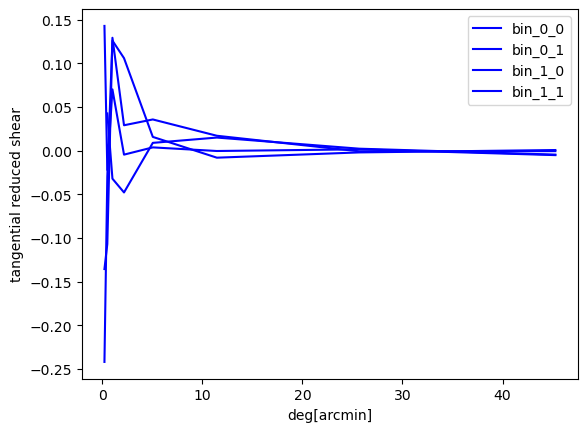

In [40]:
t1 = sacc.Sacc.load_fits("/global/homes/e/edujb/TXPipe/data/example/output_txcluster/cluster_sacc_catalog.sacc")
for k in range(0,2):
    for j in range(0,2):
        data2 = []
        radius2 = []
        for i in range(0,8):
            trac = ('cosmodc2-1deg', f'bin_rich_{j}', f'bin_z_{k}', f'radius_{i}')
            data2.append(t1.get_data_points(sacc.data_types.standard_types.cluster_shear, trac)[0].value)
            radius = t1.tracers[f'radius_{i}'].center
            radius2.append(radius)
        print(data2)
        print(data2[0])
        plt.plot(radius2, data2, color="blue", label=f'bin_{k}_{j}')
        plt.ylabel("tangential reduced shear")
        plt.xlabel("deg[arcmin]")
        plt.legend(loc='upper right')
plt.show()

## 20 deg example

In [19]:
step1 = txpipe.TXSourceSelectorMetadetect.make_stage(
    # This file is the input metadetect shear catalog
    shear_catalog=f"/global/cfs/projectdirs/lsst/groups/CL/cl_pipeline_project/TXPipe_data/cosmodc2/20deg2/shear_catalog.hdf5",
    # This is an input training set for the tomographic selection
    calibration_table=f"{my_txpipe_dir}data/example/inputs/sample_cosmodc2_w10year_errors.dat",

    # This contains all the options for this stage. You can override them here
    # manually too.
    config=f"{my_txpipe_dir}/examples/metadetect/config.yml",

    # This is the output file for this stage
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect_20/shear_tomography_catalog.hdf5"
)

In [20]:
step1.run()
step1.finalize()

Process 0 running selection for rows 0-100,000
Process 0 running selection for rows 100,000-200,000
Process 0 running selection for rows 200,000-300,000
Process 0 running selection for rows 300,000-400,000
Process 0 running selection for rows 400,000-500,000
Process 0 running selection for rows 500,000-600,000
Process 0 running selection for rows 600,000-700,000
Process 0 running selection for rows 700,000-800,000
Process 0 running selection for rows 800,000-900,000
Process 0 running selection for rows 900,000-1,000,000
Process 0 running selection for rows 1,000,000-1,100,000
Process 0 running selection for rows 1,100,000-1,200,000
Process 0 running selection for rows 1,200,000-1,300,000
Process 0 running selection for rows 1,300,000-1,400,000
Process 0 running selection for rows 1,400,000-1,500,000
Process 0 running selection for rows 1,500,000-1,600,000
Process 0 running selection for rows 1,600,000-1,700,000
Process 0 running selection for rows 1,700,000-1,800,000
Process 0 running 

In [21]:
step2 = txpipe.CLClusterBinningRedshiftRichness.make_stage(
    # This file is the input metadetect shear catalog
    cluster_catalog="/global/cfs/projectdirs/lsst/groups/CL/cl_pipeline_project/TXPipe_data/cosmodc2/20deg2/cluster_catalog.hdf5",
    # This is an input training set for the tomographic selection

    # This contains all the options for this stage. You can override them here
    # manually too.
    config=f"{my_txpipe_dir}/notebooks/cluster_counts/gt_treecor_test/config-1deg2-CL.yml",

    # This is the output file for this stage
    cluster_catalog_tomography=f"{my_txpipe_dir}/data/example/output_binning_20/cluster_catalog_tomography.hdf5"
)



In [22]:
step2.run()
step2.finalize()

In [23]:
step3 = txpipe.TXShearCalibration.make_stage(
    # This file is the input metadetect shear catalog
    shear_catalog="/global/cfs/projectdirs/lsst/groups/CL/cl_pipeline_project/TXPipe_data/cosmodc2/20deg2/shear_catalog.hdf5",
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect_20/shear_tomography_catalog.hdf5",
    binned_shear_catalog=f"{my_txpipe_dir}data/example/output_shearcalib_20/binned_shear_catalog.hdf5",
)

In [24]:
step3.run()
step3.finalize()

Copying extra columns:  []
Copying magnitude:  ['mag_i', 'mag_r', 'mag_z', 'mag_err_i', 'mag_err_r', 'mag_err_z']
Using calibration method: MetaDetectCalibrator
Reading these columns from the 'shear' group:
 - 00/g1
 - 00/g2
 - 00/ra
 - 00/dec
 - 00/weight
 - 00/mag_i
 - 00/mag_r
 - 00/mag_z
 - 00/mag_err_i
 - 00/mag_err_r
 - 00/mag_err_z
Renaming these columns:
 - 00/g1 -> g1
 - 00/g2 -> g2
 - 00/ra -> ra
 - 00/dec -> dec
 - 00/weight -> weight
 - 00/mag_i -> mag_i
 - 00/mag_r -> mag_r
 - 00/mag_z -> mag_z
 - 00/mag_err_i -> mag_err_i
 - 00/mag_err_r -> mag_err_r
 - 00/mag_err_z -> mag_err_z
Process 0 collating bins: [0, 1, 2, 3, all]
Rank 0 processing data 0 - 100,000
Rank 0 processing data 100,000 - 200,000
Rank 0 processing data 200,000 - 300,000
Rank 0 processing data 300,000 - 400,000
Rank 0 processing data 400,000 - 500,000
Rank 0 processing data 500,000 - 600,000
Rank 0 processing data 600,000 - 700,000
Rank 0 processing data 700,000 - 800,000
Rank 0 processing data 800,000 - 9

In [29]:
step3 = txpipe.extensions.cluster_counts.TXTwoPointClusterSource.make_stage(
    # This file is the input metadetect shear catalog
    shear_tomography_catalog=f"{my_txpipe_dir}/data/example/outputs_metadetect_20/shear_tomography_catalog.hdf5",
    binned_lens_catalog=f"{my_txpipe_dir}data/example/output_binning_20/cluster_catalog_tomography.hdf5",
    # This is an input training set for the tomographic selection
    binned_shear_catalog=f"{my_txpipe_dir}data/example/output_shearcalib_20/binned_shear_catalog.hdf5",
    binned_random_catalog=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",#idc
    patch_centers=f"{my_txpipe_dir}cluster_catalog_tomography.hdf5",#idc
    use_randoms= False,
    cluster_profiles = f"{my_txpipe_dir}data/example/output_txcluster_20/cluster_profiles.pkl",
    metric="Euclidean",
    var_method="shot"
)

In [30]:
step3.run()
step3.finalize()

Running with 4 source bins and 6 lens bins
Running TreeCorr with metric "Euclidean"
DOING SHEAR-POS
Skipping lens bin 2 (z=[0.400, 0.600]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 3 (z=[0.400, 0.600]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 4 (z=[0.600, 0.800]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 5 (z=[0.600, 0.800]) and source bin 0 (z=[0.500, 0.700]) — overlap detected.
Skipping lens bin 4 (z=[0.600, 0.800]) and source bin 1 (z=[0.700, 0.900]) — overlap detected.
Skipping lens bin 5 (z=[0.600, 0.800]) and source bin 1 (z=[0.700, 0.900]) — overlap detected.
Running 18 calculations: [(0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 1), (1, 2, 1), (1, 3, 1), (2, 0, 1), (2, 1, 1), (2, 2, 1), (2, 3, 1), (2, 4, 1), (2, 5, 1), (3, 0, 1), (3, 1, 1), (3, 2, 1), (3, 3, 1), (3, 4, 1), (3, 5, 1)]
Rank 0 making patches for shear catalog bin 0
Patches already done for cache/patches/TXTwoPointClusterSour

In [32]:
step3 = txpipe.extensions.cluster_counts.CLClusterSACC.make_stage(
    # This file is the input metadetect shear catalog
    cluster_profiles=f"{my_txpipe_dir}data/example/output_txcluster_20/cluster_profiles.pkl",
    cluster_sacc_catalog=f"{my_txpipe_dir}data/example/output_txcluster_20/cluster_sacc_catalog.sacc",
    clmm_profile = False,
    survey_name = "cosmodc2-20deg",
    area= 20,
)

In [34]:
step3.run()
step3.finalize()

/global/homes/e/edujb/TXPipe/data/example/output_txcluster_20/cluster_profiles.pkl
{'bin_zbin_0_richbin_0': {'radial_bins': array([  0.17407202,   0.39933906,   0.92211672,   2.14368839,
         5.00536064,  11.62815017,  26.9135804 ,  62.03356325,
       137.55238982]), 'xi': array([ 8.64410958e-04, -5.61097243e-03,  3.26284759e-03,  6.14765393e-03,
        3.12075319e-03,  1.08827062e-03,  3.14641279e-05, -8.90790203e-05,
       -2.64529054e-04]), 'cov': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'cluster_bin_edges': {'rich_min': np.float64(5.0), 'rich_max': np.float64(10.0), 'z_min': np.float64(0.2), 'z_max': np.float64(0.4)

NOTE/WARNING: Expected output file /global/homes/e/edujb/TXPipe/data/example/output_txcluster_20/cluster_sacc_catalog.sacc was not generated.


[np.float64(0.0008644109582250803), np.float64(-0.00561097243342368), np.float64(0.0032628475852526403), np.float64(0.006147653932011068), np.float64(0.0031207531930728103), np.float64(0.0010882706235916815), np.float64(3.1464127947719736e-05), np.float64(-8.907902029290128e-05)]
0.0008644109582250803
[np.float64(0.0177569055495197), np.float64(0.01012106280328318), np.float64(0.00814294949332071), np.float64(0.01663308397760685), np.float64(0.009176248960324013), np.float64(0.002800101482086858), np.float64(0.0005013704562857116), np.float64(-0.00010427900925364384)]
0.0177569055495197
[np.float64(0.004264575949335864), np.float64(0.001133556390755071), np.float64(-0.0014599269019609108), np.float64(0.0022523194088706487), np.float64(0.001348352776352251), np.float64(0.00030485762637805165), np.float64(0.0006977066507798933), np.float64(0.00015080821717624636)]
0.004264575949335864
[np.float64(0.01742152912270232), np.float64(0.004708047587156523), np.float64(0.00488497714341866), np.

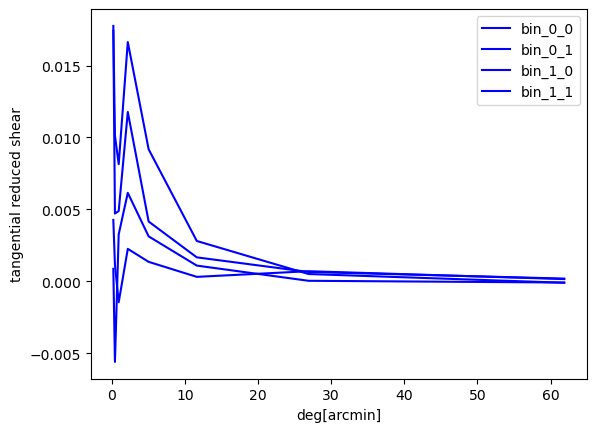

In [39]:
t1 = sacc.Sacc.load_fits("/global/homes/e/edujb/TXPipe/data/example/output_txcluster_20/cluster_sacc_catalog.sacc")
for k in range(0,2):
    for j in range(0,2):
        data2 = []
        radius2 = []
        for i in range(0,8):
            trac = ('cosmodc2-20deg', f'bin_rich_{j}', f'bin_z_{k}', f'radius_{i}')
            data2.append(t1.get_data_points(sacc.data_types.standard_types.cluster_shear, trac)[0].value)
            radius = t1.tracers[f'radius_{i}'].center
            radius2.append(radius)
        print(data2)
        print(data2[0])
        plt.plot(radius2, data2, color="blue", label=f'bin_{k}_{j}')
        plt.ylabel("tangential reduced shear")
        plt.xlabel("deg[arcmin]")
        plt.legend(loc='upper right')
plt.show()